In [20]:
import fluidsynth
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [21]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name)) #피아노를 넣으면 피아노가 있는 경우에 그것의 맞는 Pretty midi instrument 숫자를 리턴

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [22]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [23]:
def midi_to_notes(midi_file: str):
  try:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0] #val of single instrument
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
      start = note.start
      end = note.end
      notes['pitch'].append(note.pitch)
      notes['start'].append(start)
      notes['end'].append(end)
      notes['step'].append(start - prev_start)
      notes['duration'].append(end - start)
      prev_start = start
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})
  except OSError as e:
    print(f"Error processing MIDI file '{midi_file}': {e}")
  except ValueError as ve:
    print(f"ValueError occurred while processing file {midi_file}: {ve}")
  except Exception as e:
    print(f"Error occurred while processing file {midi_file}: {e}")


In [24]:
# dictionary 를 넣어서 미디 파일로 받기. 나중에 악기들 합친 후에 미디 파일 생성할때 쓰일 펑션.
def dict_to_midi(
        instrument_notes_dict : dict,
        out_file: str):
    
        combined_pm = pretty_midi.PrettyMIDI()
        for instrument_name, notes_df in instrument_notes_dict.items():
                instrument = pretty_midi.Instrument(
                program=pretty_midi.instrument_name_to_program(
                        instrument_name))
    
        
                prev_start = 0
                for i, note in notes_df.iterrows():
                        start = float(prev_start + note['step'])
                        end = float(start + note['duration'])
                        note = pretty_midi.Note(
                                velocity=100,
                                pitch=int(note['pitch']),
                                start=start,
                                end=end,
                        )
                        instrument.notes.append(note)
                        prev_start = start
                
                combined_pm.instruments.append(instrument)
        combined_pm.write(out_file)
        return combined_pm

In [25]:
_SAMPLING_RATE = 16000

#오디오를 30초간 들을수 있는 펑션
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [26]:
pm = pretty_midi.PrettyMIDI('MIDI/pop/Yazoo/Smile.mid')
print(pm.instruments[7])


Instrument(program=53, is_drum=False, name="Staff-4")


In [29]:
# instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(pm.instruments[7]))
# instrument

In [30]:
raw_notes = midi_to_notes('sample/mixture1.mid')
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
instrument_name

'Acoustic Grand Piano'

In [14]:
example_file = 'sample/test.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [19]:
out_file = 'sample/test1.mid'
out_pm = dict_to_midi(raw_notes, out_file)
display_audio(out_pm)

ValueError: pitch is not a valid General MIDI instrument name.

In [15]:
display_audio(example_pm)

In [17]:
display_audio(pm)

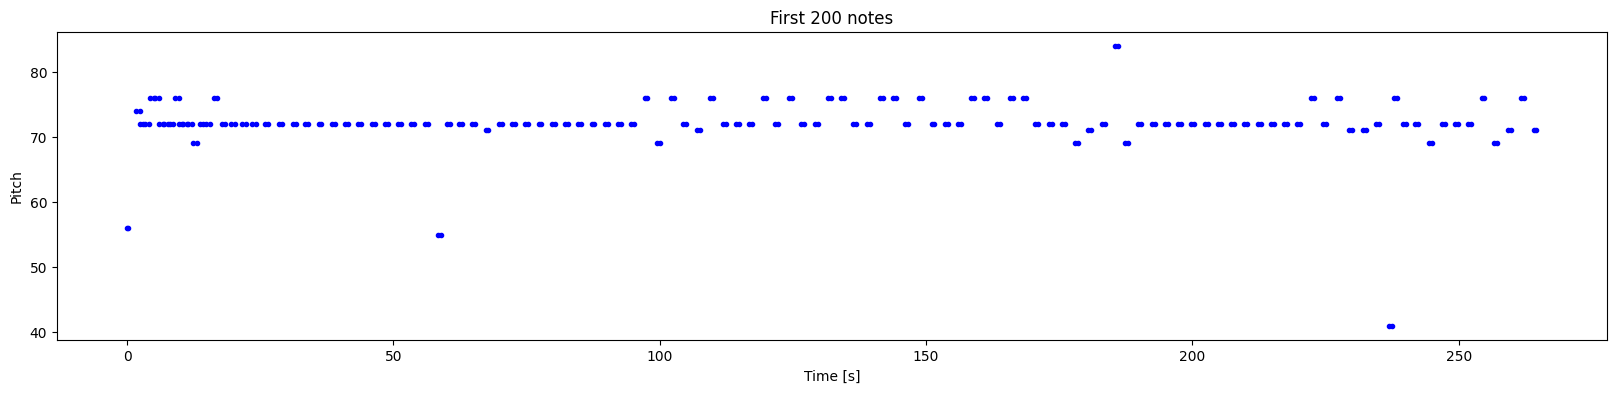

In [31]:
plot_piano_roll(raw_notes, count=200)

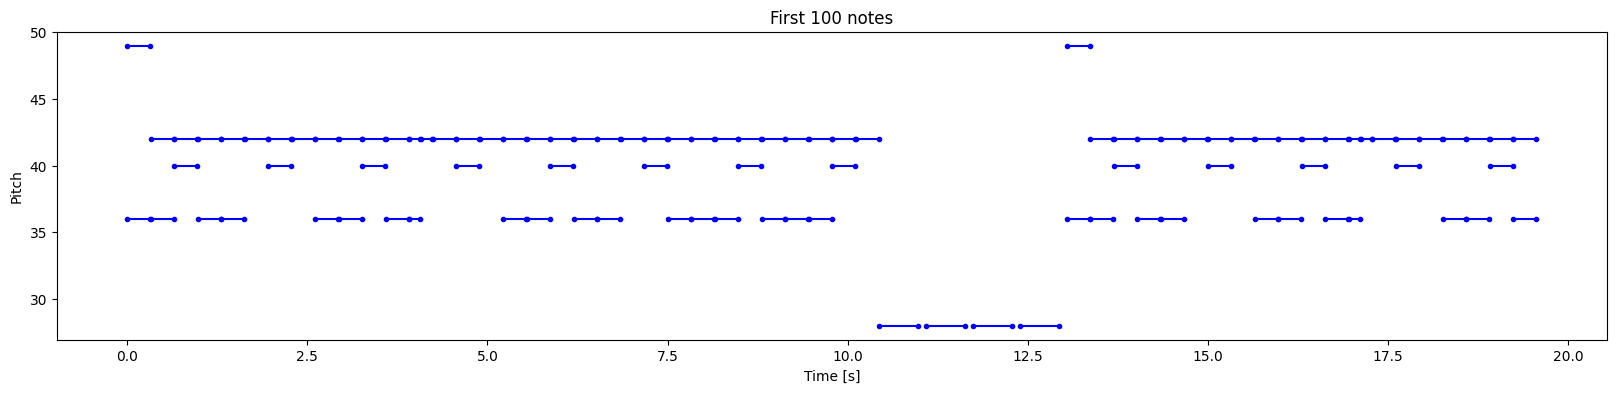

In [ ]:
plot_piano_roll(raw_notes, count=200)